# Exploring the NASDAQOMX india indices

In [1]:
library(DBI)
library(plutoDbR)
library(plutoR)
library(tidyverse)
options("scipen"=999)
options(stringsAsFactors = FALSE)
source("/usr/share/pluto/config.R")
source("/usr/share/pluto/goofy/plot.common.R")
source("/usr/share/pluto/goofy/misc.common.R")

library(ggthemes)
library(quantmod)
library(PerformanceAnalytics)

options(repr.plot.width=16, repr.plot.height=8)

nasdaqOmx <- NasdaqOmx()

In [2]:
indexMeta <- nasdaqOmx$Meta() %>%
    inner_join(nasdaqOmx$TimeSeries()) %>%
    group_by(ID, CODE, NAME) %>%
    filter(NAME %like% '% India %') %>%
    summarize(ST = min(TIME_STAMP), ET = max(TIME_STAMP)) %>%
    arrange(NAME) %>%
    collect()

indexMeta %>%
    print(n = Inf, width = Inf)

# A tibble: 11 x 5
# Groups:   ID, CODE [11]
         ID CODE      NAME                                          ST        
 *    <int> <chr>     <chr>                                         <chr>     
 1 13120874 NQIN1000T NASDAQ India Basic Matls TR Index (NQIN1000T) 2001-03-30
 2 13120916 NQIN3000T NASDAQ India Cnsmr Goods TR Index (NQIN3000T) 2001-03-30
 3 13120939 NQIN5000T NASDAQ India Cnsmr Svcs TR Index (NQIN5000T)  2005-03-31
 4 13120986 NQIN8000T NASDAQ India Financials TR Index (NQIN8000T)  2001-03-30
 5 13121029 NQIN4000T NASDAQ India Health Care TR Index (NQIN4000T) 2001-03-30
 6 13121072 NQIN2000T NASDAQ India Inds TR Index (NQIN2000T)        2001-03-30
 7 13121187 NQIN0001T NASDAQ India Oil & Gas TR Index (NQIN0001T)   2004-09-30
 8 13121253 NQIN9000T NASDAQ India Tech TR Index (NQIN9000T)        2001-03-30
 9 13121274 NQIN6000T NASDAQ India Telecom TR Index (NQIN6000T)     2006-03-31
10 13121272 NQINT     NASDAQ India TR Index (NQINT)                 2001-03-30
11 1312

In [4]:
#grab the data
startDate <- max(indexMeta$ST)
endDate <- min(indexMeta$ET)

nqRets <- NULL

for(id in indexMeta$ID){
    nqVals <- nasdaqOmx$TimeSeries() %>%
        filter(ID == id & TIME_STAMP >= startDate & TIME_STAMP <= endDate) %>%
        select(TIME_STAMP, CLOSE) %>%
        collect() %>%
        mutate(TIME_STAMP = as.Date(TIME_STAMP))
    
    nqRets <- merge.xts(nqRets, dailyReturn(xts(nqVals$CLOSE, nqVals$TIME_STAMP)))
}

names(nqRets) <- indexMeta$CODE

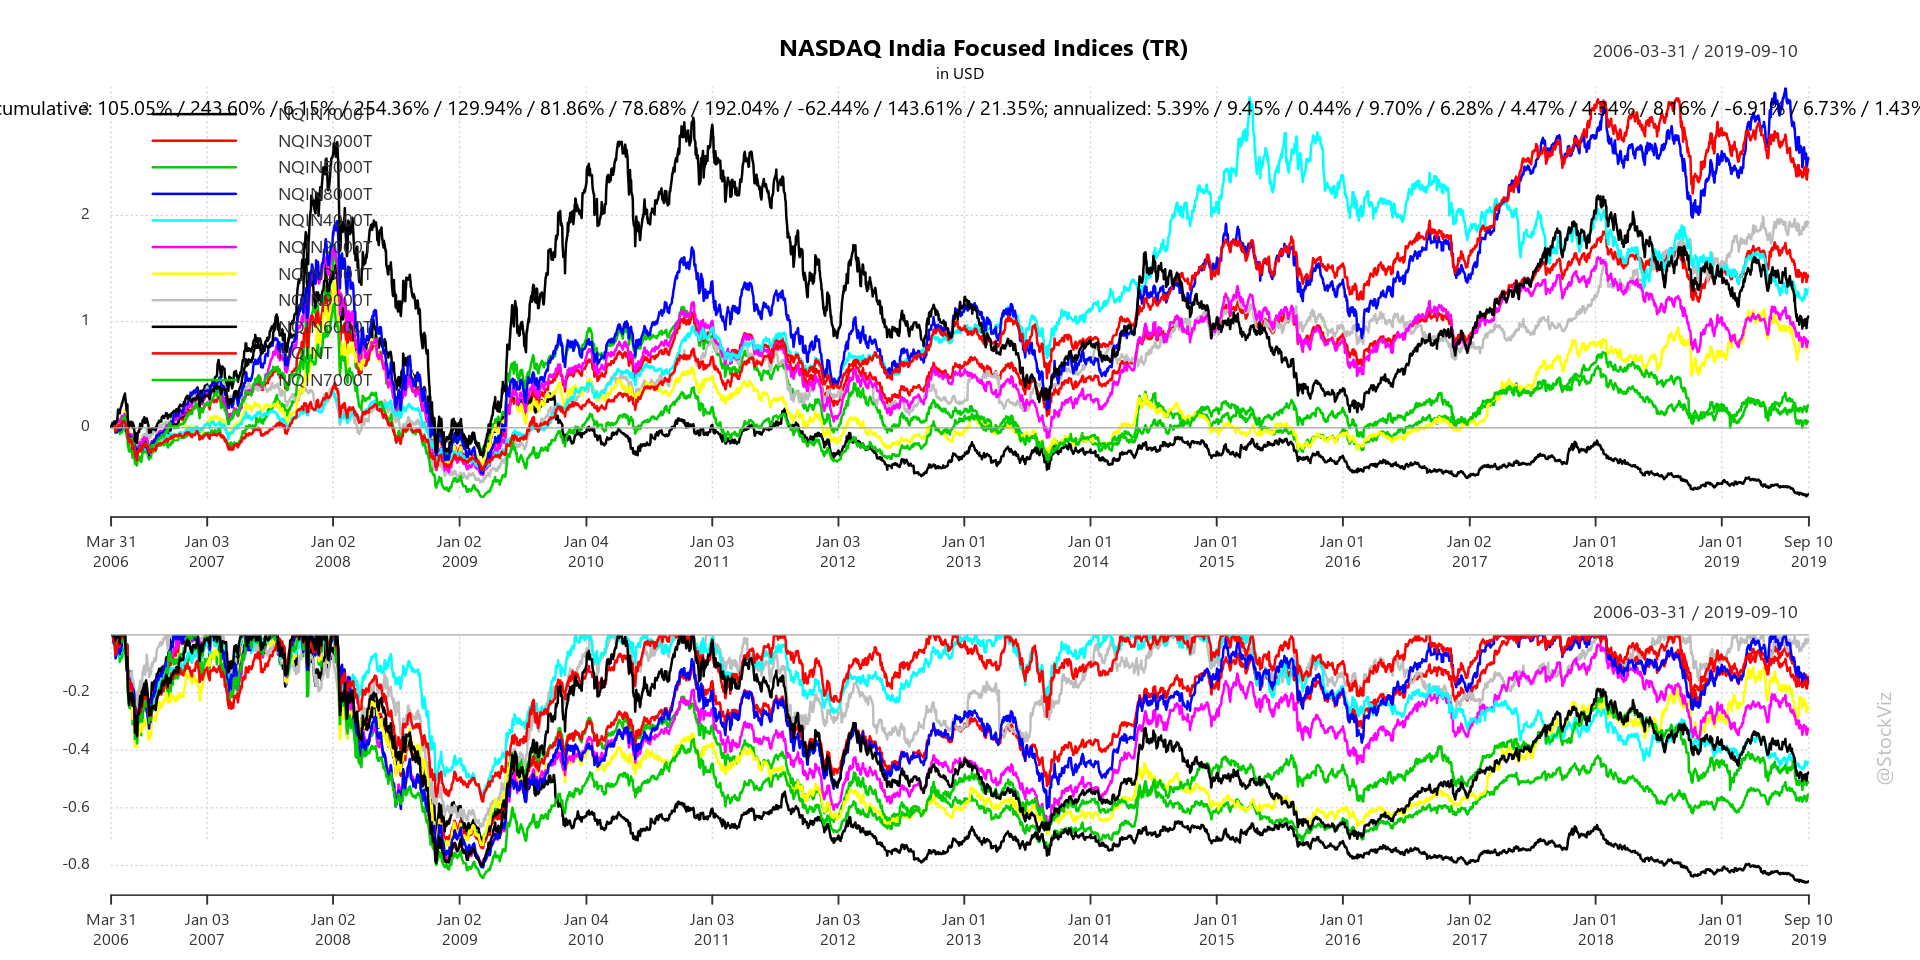

In [5]:
#plot cumulative returns
Common.PlotCumReturns(nqRets, "NASDAQ India Focused Indices (TR)", "in USD")

In [6]:
#returns in a table

retDf <- data.frame(NAME="", CUMULATIVE=0.0, ANNUALIZED=0.0)
for(j in 1:ncol(nqRets)){
    retDf <- rbind(retDf, c(toString(indexMeta$NAME[j]), 
                            100*as.numeric(Return.cumulative(nqRets[,j])), 
                            100*as.numeric(Return.annualized(nqRets[,j]))))
}
retDf <- retDf[-1,]
retDf[,2] <- round(as.numeric(retDf[,2]), 2)
retDf[,3] <- round(as.numeric(retDf[,3]), 2)

print(retDf)

                                            NAME CUMULATIVE ANNUALIZED
2  NASDAQ India Basic Matls TR Index (NQIN1000T)     105.05       5.39
3  NASDAQ India Cnsmr Goods TR Index (NQIN3000T)     243.60       9.45
4   NASDAQ India Cnsmr Svcs TR Index (NQIN5000T)       6.15       0.44
5   NASDAQ India Financials TR Index (NQIN8000T)     254.36       9.70
6  NASDAQ India Health Care TR Index (NQIN4000T)     129.94       6.28
7         NASDAQ India Inds TR Index (NQIN2000T)      81.86       4.47
8    NASDAQ India Oil & Gas TR Index (NQIN0001T)      78.68       4.34
9         NASDAQ India Tech TR Index (NQIN9000T)     192.04       8.16
10     NASDAQ India Telecom TR Index (NQIN6000T)     -62.44      -6.91
11                 NASDAQ India TR Index (NQINT)     143.61       6.73
12   NASDAQ India Utilities TR Index (NQIN7000T)      21.35       1.43


This notebook was created using [pluto](http://pluto.studio). Learn more [here](https://github.com/shyams80/pluto)